In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [58]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, RepeatVector, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [59]:
plt.rcParams['figure.figsize'] = (12,8)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
# Note we have reduced the data set to 50K+,50K+ and 25+K Lines considering timelines, resources and cleaned up of garbage data  
# Read the text file content data into Dataframes using pandas libraries.
#----------------------------------------------------------------------------------------------------#
en_europarl_df0 = pd.read_table('/content/drive/My Drive/europarl-v7_en_de.txt', header=None, names=['English'], encoding='utf-8')
de_europarl_df0 = pd.read_table('/content/drive/My Drive/europarl-v7_de_en.txt', header=None, names=['German'], encoding='utf-8')

#---------------------------------------------------------------------------------------------------#
en_commoncrawl_df0 = pd.read_table('/content/drive/My Drive/commoncrawl_en_de.txt', header=None, names=['EN_Commoncrawl'], encoding='utf-8')
de_commoncrawl_df0 = pd.read_table('/content/drive/My Drive/commoncrawl_de_en.txt', header=None, names=['DE_Commoncrawl'], encoding='utf-8')
#--------------------------------------------------------------------------------------------------#

en_news_commentary_df0 = pd.read_table('/content/drive/My Drive/news-commentary-v9_en_de.txt', header=None, encoding='utf-8',
                                      lineterminator='\n',names=['EN_News_commentary'])
de_news_commentary_df0 = pd.read_table('/content/drive/My Drive/news-commentary-v9_de_en.txt', header=None, encoding='utf-8',
                                      lineterminator='\n',names=['DE_News_commentary'])
#--------------------------------------------------------------------------------------------------#

In [61]:
print('\n--------------------------------------------------------\n')
print("English_News_Count: ",en_europarl_df0.count())
print("German_News_Count:  ",de_europarl_df0.count())
print('\n--------------------------------------------------------\n')
print("English_Commoncrawl_Count: ",en_commoncrawl_df0.count())
print("German_Commoncrawl_Count:  ",de_commoncrawl_df0.count())
print('\n--------------------------------------------------------\n')
# We can observe even after spliting the data default at '/n' character only,
# the number of rows on EN and DE side are not matching.
print("English_News_Count: ",en_news_commentary_df0.count())
print("German_News_Count:  ",de_news_commentary_df0.count())
print('\n--------------------------------------------------------\n')
# Same trend of not matching rowcount for EN and DE is obsereved, in this europarl set as well.


--------------------------------------------------------

English_News_Count:  English    49781
dtype: int64
German_News_Count:   German    49901
dtype: int64

--------------------------------------------------------

English_Commoncrawl_Count:  EN_Commoncrawl    18057
dtype: int64
German_Commoncrawl_Count:   DE_Commoncrawl    18868
dtype: int64

--------------------------------------------------------

English_News_Count:  EN_News_commentary    19975
dtype: int64
German_News_Count:   DE_News_commentary    19966
dtype: int64

--------------------------------------------------------



In [62]:
# open the sampled file : europarl_en, 
file_europarl_en = open('/content/drive/My Drive/europarl-v7_en_de.txt', encoding='utf-8')
file_europarl_de = open('/content/drive/My Drive/europarl-v7_de_en.txt', encoding='utf-8')
# read the content of the file opened
europarl_en = file_europarl_en.readlines()
europarl_de = file_europarl_de.readlines()
en_europarl_df = pd.DataFrame(europarl_en, columns=['English'])
de_europarl_df = pd.DataFrame(europarl_de, columns = ['German'])
##----------------------------------------------------------------##  
# open the sampled file : commoncrawl_en, commoncrawl_de 
file_commoncrawl_en = open('/content/drive/My Drive/commoncrawl_en_de.txt', encoding='utf-8')
file_commoncrawl_de = open('/content/drive/My Drive/commoncrawl_de_en.txt', encoding='utf-8')
# read the content of the file opened
commoncrawl_en = file_commoncrawl_en.readlines()
commoncrawl_de = file_commoncrawl_de.readlines()
en_commoncrawl_df = pd.DataFrame(commoncrawl_en, columns=['EN_commoncrawl'])
de_commoncrawl_df = pd.DataFrame(commoncrawl_de, columns=['DE_commoncrawl'])
##----------------------------------------------------------------##
# open the sampled file : commoncrawl_en, commoncrawl_de 
file_news_commentary_en = open('/content/drive/My Drive/news-commentary-v9_en_de.txt', encoding='utf-8')
file_news_commentary_de = open('/content/drive/My Drive/news-commentary-v9_de_en.txt', encoding='utf-8')
# read the content of the file opened
news_commentary_en = file_news_commentary_en.readlines()
news_commentary_de = file_news_commentary_de.readlines()
en_news_commentary_df = pd.DataFrame(news_commentary_en, columns=['EN_News_Commentary'])
de_news_commentary_df = pd.DataFrame(news_commentary_de, columns=['DE_News_Commentary'])
##----------------------------------------------------------------##
print('\n--------------------------------------------------------\n')
print("English_News_Count: ",en_europarl_df.count())
print("German_News_Count:  ",de_europarl_df.count())
print('\n--------------------------------------------------------\n')
# We can observe with UTF encoding and reading the file with stream/list appraoch we were able to success fully load 
# test data into pandas dataframe. 
print("English_Commoncrawl_Count: ",en_commoncrawl_df.count())
print("German_Commoncrawl_Count:  ",de_commoncrawl_df.count())
print('\n--------------------------------------------------------\n')
# the number of rows on EN and DE side are matching.
print("English_News_Count: ",en_news_commentary_df.count())
print("German_News_Count:  ",de_news_commentary_df.count())
print('\n--------------------------------------------------------\n')
# Same trend of matching rowcount for EN and DE is obsereved, in this news commentry set as well.


--------------------------------------------------------

English_News_Count:  English    50001
dtype: int64
German_News_Count:   German    50001
dtype: int64

--------------------------------------------------------

English_Commoncrawl_Count:  EN_commoncrawl    20001
dtype: int64
German_Commoncrawl_Count:   DE_commoncrawl    20001
dtype: int64

--------------------------------------------------------

English_News_Count:  EN_News_Commentary    20001
dtype: int64
German_News_Count:   DE_News_Commentary    20001
dtype: int64

--------------------------------------------------------



In [64]:
#Merge En and DE based DF into one DF
#------------------------------------------------------------------------------------------#
news_commentary_df =  pd.DataFrame()
en_news_commentary_df.join(de_news_commentary_df)
pd.merge(en_news_commentary_df, de_news_commentary_df, left_index=True, right_index=True)
news_commentary_df = pd.concat([en_news_commentary_df, de_news_commentary_df], axis=1)
#------------------------------------------------------------------------------------------#
en_commoncrawl_df.join(de_commoncrawl_df)
pd.merge(en_commoncrawl_df, de_commoncrawl_df, left_index=True, right_index=True)
commoncrawl_df = pd.concat([en_commoncrawl_df, de_commoncrawl_df], axis=1)
#------------------------------------------------------------------------------------------#
en_europarl_df.join(de_europarl_df)
pd.merge(en_europarl_df, de_europarl_df, left_index=True, right_index=True)
europarl_df = pd.concat([en_europarl_df, de_europarl_df], axis=1)
#------------------------------------------------------------------------------------------#

In [65]:
#Free up non-used default allocated memory
del [en_news_commentary_df, de_news_commentary_df,en_news_commentary_df0, de_news_commentary_df0]
del [en_commoncrawl_df, de_commoncrawl_df, en_commoncrawl_df0, de_commoncrawl_df0]
del [en_europarl_df, de_europarl_df, en_europarl_df0, de_europarl_df0]

In [66]:
#Step 2A: Merge all the three datasets. [ 1 point ]
df =  pd.DataFrame()
event_df=  pd.DataFrame()
#------------------------------------------------------------------------------------------#
news_commentary_df.join(commoncrawl_df)
pd.merge(news_commentary_df, commoncrawl_df, left_index=True, right_index=True)
event_df = pd.concat([news_commentary_df, commoncrawl_df], axis=1)
#------------------------------------------------------------------------------------------#
event_df.join(europarl_df)
pd.merge(event_df, europarl_df, left_index=True, right_index=True)
df = pd.concat([event_df, europarl_df], axis=1)
#------------------------------------------------------------------------------------------#
#Free up non-used default allocated memory
del [event_df]

In [11]:
df.duplicated().sum()

392

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

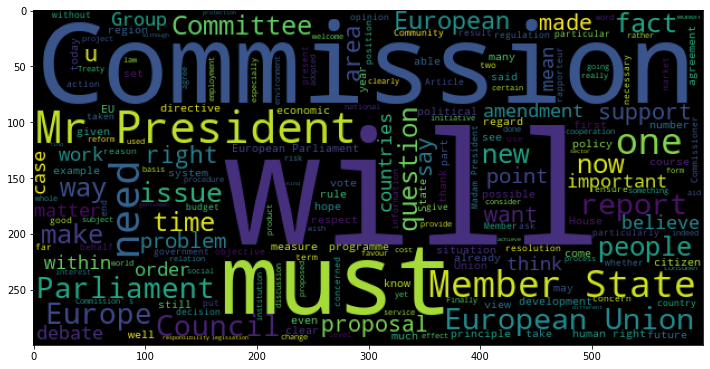

In [14]:
wc_en = WordCloud(width=600,height=300).generate(' '.join(df.English))
plt.imshow(wc_en);

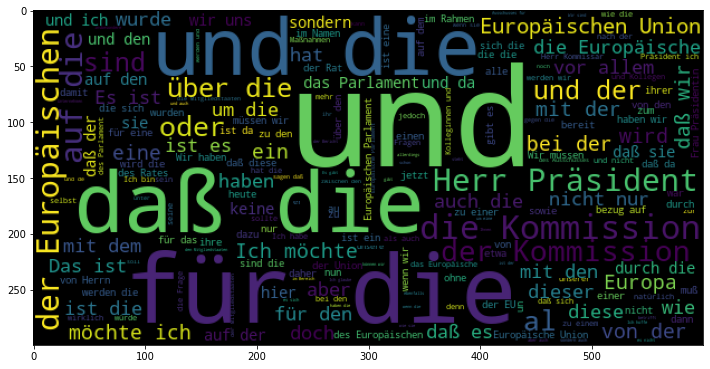

In [67]:
wc_de = WordCloud(width=600,height=300).generate(' '.join(df.German))
plt.imshow(wc_de);

In [73]:
df['eng_len'] = df.English.apply(len)
df['ger_len'] = df.German.apply(len)

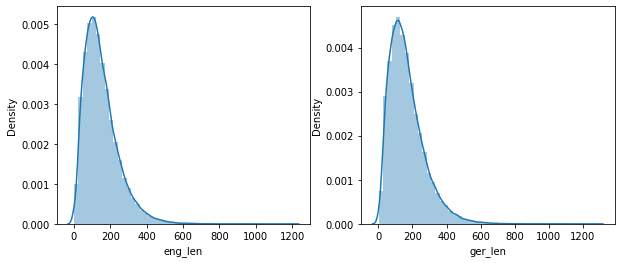

In [74]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.distplot(df.eng_len,ax=axes[0])
sns.distplot(df.ger_len,ax=axes[1])

In [75]:
df.describe()

eng_len       ger_len
count  50001.000000  50001.000000
mean     150.364893    166.823804
std       93.972379    105.183431
min        1.000000      1.000000
25%       83.000000     91.000000
50%      132.000000    146.000000
75%      197.000000    219.000000
max     1203.000000   1284.000000

In [76]:
max_eng_len = 100
max_ger_len = 100

In [77]:
def clean_text(text):
    text = text.lower()  
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    return text

In [78]:
df.English = df.English.progress_apply(clean_text)
df.German = df.German.progress_apply(clean_text)

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

In [79]:
df.English = df.English.apply(lambda x: '<START> ' + x + ' <END>')

In [83]:
df.English.head()

0              <START> resumption of the session <END>
1    <START> i declare resumed the session of the e...
2    <START> although  as you will have seen  the d...
3    <START> you have requested a debate on this su...
4    <START> in the meantime  i should like to obse...
Name: English, dtype: object

In [84]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df.English.head(6000))

In [85]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

8574

In [86]:
eng_sequences = eng_tokenizer.texts_to_sequences(df.English.head(6000))
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')

In [87]:
ger_tokenizer = Tokenizer()
ger_tokenizer.fit_on_texts(df.German.head(6000))

In [88]:
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_vocab_size

14427

In [89]:
ger_sequences = ger_tokenizer.texts_to_sequences(df.German.head(6000))
ger_pad_sequences = pad_sequences(ger_sequences,maxlen=max_ger_len,dtype='int32',padding='post',truncating='post')

In [90]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [91]:
K.clear_session()

latent_dim = 300 
embedding_dim = 100 

encoder_inputs = Input(shape=(max_eng_len,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_output2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(ger_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 

attn_layer = AttentionLayer(name='attention_layer') 
attn_outputs, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

decoder_dense = TimeDistributed(Dense(ger_vocab_size,activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     857400      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

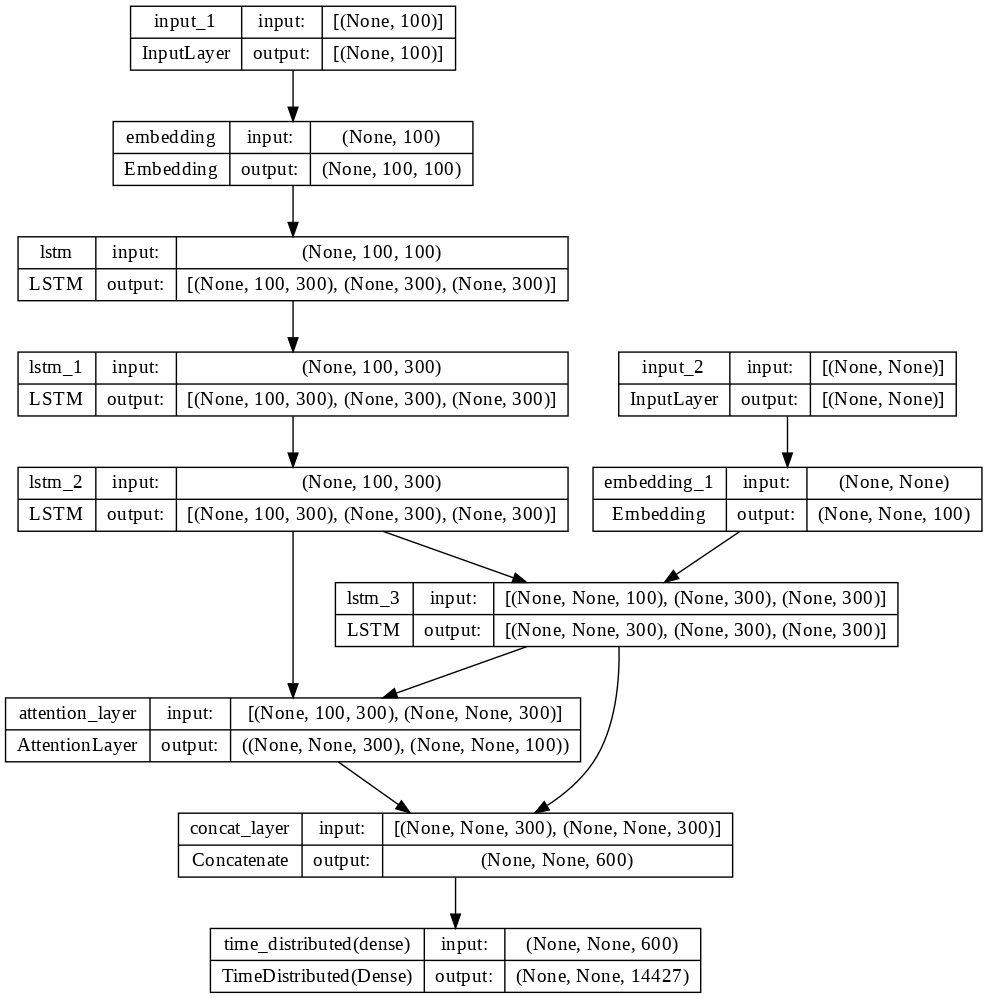

In [92]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [93]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [94]:
 X_train, X_test, y_train, y_test = train_test_split(ger_pad_sequences, eng_pad_sequences, test_size=0.25,shuffle=True,random_state=101)

In [95]:
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

r = model.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=30,
             batch_size=256,
             callbacks=[es,rl,mc],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 3.3217 - accuracy: 0.6889
Epoch 1: val_accuracy improved from -inf to 0.73446, saving model to checkpoint/
18/18 [==============================] - 94s 5s/step - loss: 3.3217 - accuracy: 0.6889 - val_loss: 2.0004 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 1.9878 - accuracy: 0.7337
Epoch 2: val_accuracy improved from 0.73446 to 0.73610, saving model to checkpoint/
18/18 [==============================] - 79s 4s/step - loss: 1.9878 - accuracy: 0.7337 - val_loss: 1.9833 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 1.8368 - accuracy: 0.7356
Epoch 3: val_accuracy improved from 0.73610 to 0.74039, saving model to checkpoint/
18/18 [==============================] - 79s 4s/step - loss: 1.8368 - accuracy: 0.7356 - val_loss: 1.7574 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 4/30
18/18 [=========================

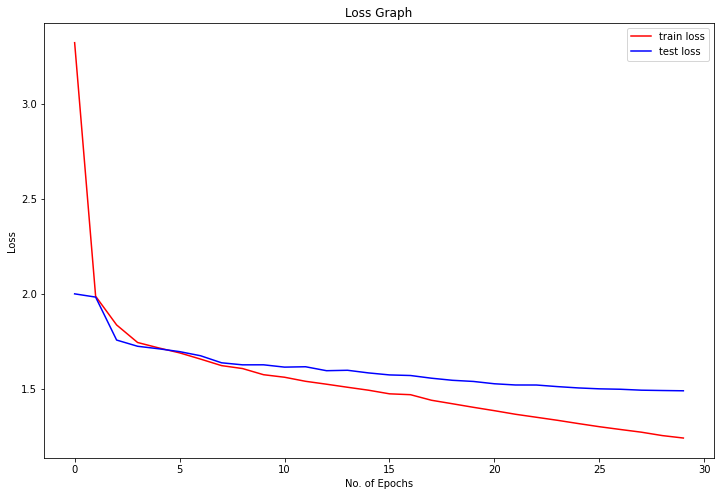

In [96]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

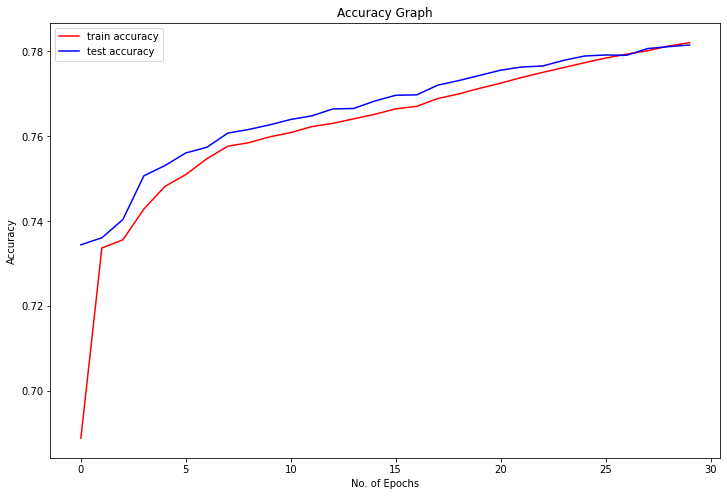

In [97]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [98]:
model.evaluate([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:])

47/47 [==============================] - 11s 236ms/step - loss: 1.4905 - accuracy: 0.7815


[1.4904791116714478, 0.7815218567848206]

In [99]:
model.save('english_to_german_translator_er_f.h5')
lm = load_model('english_to_german_translator_er_f.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [100]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_eng_len, latent_dim))

decoder_out, decoder_state_a, decoder_state_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat_outputs = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat_outputs)
decoder_model = Model([decoder_inputs]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_state_a, decoder_state_c])

In [101]:
def decode_sequences(input_sequence):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_sequence)
    next_input = np.zeros((1,1))
    next_input[0,0] = eng_tokenizer.word_index['start']
    output_sequence = ''
    flag = False
    while not flag:
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        output_idx = np.argmax(decoded_out[0, -1, :])
        if output_idx == eng_tokenizer.word_index['end']: 
            flag = True
        elif output_idx > 0 and output_idx != eng_tokenizer.word_index['start']:
            output_token = eng_tokenizer.index_word[output_idx] 
            output_sequence = output_sequence + ' ' + output_token 
        next_input[0,0] = output_idx
        # Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_sequence     

In [102]:
def sequence_to_language(input_sequence,tokenizer,lang):
    res = ''
    
    if lang == 'ger':
        for idx in input_sequence:
            if idx != 0:
                res = res + tokenizer.index_word[idx] + ' '
    
    elif lang == 'eng':
        for idx in input_sequence:
            if idx > 0:
                if tokenizer.index_word[idx] != 'start' and tokenizer.index_word[idx] != 'end':
                    res = res + tokenizer.index_word[idx] + ' '
                    
    return res

In [103]:
def predicted_sequence_to_ger_language(input_sequence):
    res = ''
    
    for idx in input_sequence:
        if idx > 0:
            if ger_tokenizer.index_word[idx] != 'start' and ger_tokenizer.index_word[idx] != 'end':
                res = res + ger_tokenizer.index_word[idx] + ' '
    
    return res

In [105]:
predicted_english_translations= []

for i in range(5, 21):
    print("German Sentence:",sequence_to_language(X_test[i], ger_tokenizer, 'ger'))
    print("Original English Translation:",sequence_to_language(y_test[i],eng_tokenizer,'eng'))
    pred_english_sentence = decode_sequences(X_test[i].reshape(1,max_eng_len))
    print("Predicted English Translation:",pred_english_sentence)
    predicted_english_translations.append(pred_english_sentence)

German Sentence: heute ist nicht im geringsten absehbar wann das cen imstande sein wird uns konkrete vorschläge zu machen 
Original English Translation: right now we do not have the slightest idea as to when the cen will be in a position to put forward practical proposals 
1/1 [==============================] - 0s 16ms/step
Predicted English Translation:  the commission is not been a number of the european union s institutions
German Sentence: unserer überzeugung nach sollte nahezu jede empfehlung aus dem bericht der weisen umgesetzt werden 
Original English Translation: we believe the vast number of recommendations of the wise men s report should be implemented 
1/1 [==============================] - 0s 18ms/step
Predicted English Translation:  the second hulten is closed of the european union s party and the commission s capita of the european union
German Sentence: es muß auch weiterhin möglich sein daß der finanzkontrolleur prüft bevor mittelbindungen oder zahlungen erfolgen nicht 

In [ ]:
original_ger_translations = []
for i in range(20):
    original_ger_translations.append(sequence_to_language(y_test[i],ger_tokenizer,'ger'))
references = []

for trans in original_ger_translations:
    ref = trans.split()
    references.append(ref)

In [ ]:
orig_ger_sents = []
smooth = SmoothingFunction().method4

for i in range(0, 16):
    print("Original German Sentence:",references[i])
    print("Predicted German Sentence:",predicted_ger_translations[i])
    print("BLEU Score:",sentence_bleu(references[i],predicted_ger_translations[i],weights=(0.25,0.25,0.25,0.25)))

Original German Sentence: ['ich', 'behaupte', 'jedoch', 'er', 'kann', 'und', 'will', 'genauso', 'wenig', 'wie', 'andere', 'rechtsextreme', 'bewegungen', 'in', 'dieses', 'in', 'unser', 'politisches', 'system', 'und', 'in', 'dieses', 'europa', 'integriert', 'werden']
Predicted German Sentence:  ich ist ich nicht daß die kommission von den tobin steuer und die tobin steuer und die einhaltung der kommission und den südlibanon des vorsorgeprinzips zu tun
BLEU Score: 2.335647905919343e-78
Original German Sentence: ['was', 'können', 'nun', 'die', 'abgeordneten', 'des', 'europäischen', 'parlaments', 'angesichts', 'einer', 'derartigen', 'katastrophe', 'tun']
Predicted German Sentence:  ich denke ich daß die kommission in den morgigen monaten
BLEU Score: 0.11023694672787128
Original German Sentence: ['ohne', 'schwäche', 'ohne', 'selbstgefälligkeit', 'ohne', 'zweideutigkeit', 'aber', 'im', 'dienste', 'der', 'gesamten', 'union', 'und', 'jedes', 'einzelnen', 'mitgliedstaats', 'und', 'seiner', 'bürg

IndexError: ignored